# Clinical Data - Exploratory Data Analysis (EDA)

This notebook provides comprehensive exploratory data analysis for the clinical ML dataset, including:

1. **Data Overview**: Basic statistics and data quality assessment
2. **Target Analysis**: Target variable distribution and characteristics
3. **Feature Distributions**: Univariate analysis of all features
4. **Correlation Analysis**: Feature relationships and multicollinearity
5. **Demographic Analysis**: Patient characteristics and segmentation
6. **Temporal Patterns**: Time-based trends and seasonality
7. **Missing Data Analysis**: Patterns and handling strategies
8. **Outlier Detection**: Identification of anomalous observations
9. **Feature Engineering Insights**: Recommendations for new features
10. **Data Quality Assessment**: Issues and recommendations

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from pathlib import Path
import yaml
from datetime import datetime

# Statistical libraries
from scipy import stats
from scipy.stats import chi2_contingency, normaltest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

# Configure settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

# Configure plotly
import plotly.io as pio
pio.templates.default = "plotly_white"

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Overview

In [2]:
# Load the clinical dataset
data_path = '../data/raw/clinical_data.parquet'
df = pd.read_parquet(data_path)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display basic info
print("\n=== Dataset Info ===")
df.info()

Dataset loaded successfully!
Shape: (1537514, 29)
Memory usage: 685.52 MB

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537514 entries, 0 to 1537513
Data columns (total 29 columns):
 #   Column                Non-Null Count    Dtype   
---  ------                --------------    -----   
 0   patient_id            1537514 non-null  object  
 1   age                   1537514 non-null  int64   
 2   gender                1537514 non-null  object  
 3   bmi                   1537514 non-null  float64 
 4   systolic_bp           1537514 non-null  float64 
 5   diastolic_bp          1537514 non-null  float64 
 6   cholesterol           1537514 non-null  float64 
 7   glucose               1537514 non-null  float64 
 8   smoking_status        1537514 non-null  object  
 9   num_visits            1537514 non-null  int64   
 10  medications_count     1537514 non-null  int64   
 11  lab_abnormal_flag     1537514 non-null  bool    
 12  primary_diagnosis     1537514 

In [3]:
# First look at the data
print("=== First 5 rows ===")
display(df.head())

print("\n=== Last 5 rows ===")
display(df.tail())

print("\n=== Random sample ===")
display(df.sample(5, random_state=42))

=== First 5 rows ===


,patient_id,age,gender,bmi,systolic_bp,diastolic_bp,cholesterol,glucose,smoking_status,num_visits,medications_count,lab_abnormal_flag,primary_diagnosis,additional_diagnoses,birth_year,target,age_group,bmi_category,noise_feature_0,noise_feature_1,noise_feature_2,noise_feature_3,noise_feature_4,noise_feature_5,noise_feature_6,noise_feature_7,noise_feature_8,noise_feature_9,year
0,P000000,34,F,21.1,143.2,78.2,242.9,111.6,Current,3,0,True,M25,,1981,0,31-45,Normal,0.497,-0.244,0.095,-1.059,0.109,1.416,0.763,-0.620,-1.510,-0.196,2015
1,P000001,68,F,26.2,140.0,71.0,230.2,118.9,Never,4,0,False,M79,E03,1947,0,61-75,Overweight,-0.234,-0.586,-0.802,0.322,0.944,0.460,0.285,-0.429,-1.574,-0.923,2015
2,P000002,68,F,26.3,140.6,63.8,224.9,84.1,Never,7,3,True,E78,,1947,0,61-75,Overweight,-0.463,1.182,0.398,1.056,2.256,-0.049,-0.623,-0.113,1.739,1.308,2015
3,P000003,47,F,31.1,121.5,89.5,188.6,102.4,Former,3,0,False,E78,,1968,0,46-60,Obese,-0.562,-0.354,-0.287,-1.364,-1.001,0.409,0.056,-2.459,-1.242,-0.829,2015
4,P000004,69,M,20.5,136.7,94.4,271.7,72.4,Never,1,0,False,M25,I25,1946,0,61-75,Normal,1.466,1.932,0.094,0.717,-0.358,0.152,-0.623,-0.119,0.190,0.653,2015



=== Last 5 rows ===


,patient_id,age,gender,bmi,systolic_bp,diastolic_bp,cholesterol,glucose,smoking_status,num_visits,medications_count,lab_abnormal_flag,primary_diagnosis,additional_diagnoses,birth_year,target,age_group,bmi_category,noise_feature_0,noise_feature_1,noise_feature_2,noise_feature_3,noise_feature_4,noise_feature_5,noise_feature_6,noise_feature_7,noise_feature_8,noise_feature_9,year
1537509,P049995,21,F,27.6,112.1,86.5,200.1,97.6,Never,0,0,False,E78,,1998,0,18-30,Overweight,-0.914,-1.834,-0.296,-1.448,0.223,0.020,0.728,0.242,0.452,-0.950,2019
1537510,P049996,79,M,21.2,117.7,82.2,267.4,115.6,Never,5,2,False,N18,E03,1940,0,75+,Normal,0.823,-0.531,1.326,0.146,-0.744,-0.863,2.107,0.645,0.367,0.683,2019
1537511,P049997,67,M,25.3,127.6,84.5,227.5,109.6,Never,2,2,False,E11,I48,1952,0,61-75,Overweight,1.005,0.254,1.028,-0.965,-0.120,-1.165,-0.689,0.346,0.805,0.382,2019
1537512,P049998,76,M,26.0,136.3,79.1,262.8,100.1,Never,4,1,False,I25,"K21,I25",1943,0,75+,Overweight,0.271,-1.070,-0.009,-0.110,-3.511,-0.491,-1.432,0.104,0.271,0.030,2019
1537513,P049999,35,M,29.5,119.4,87.4,183.1,91.5,Current,4,0,False,I48,,1984,0,31-45,Overweight,0.249,0.928,-0.765,0.147,-1.488,-1.340,1.146,-1.544,-0.251,-0.175,2019



=== Random sample ===


,patient_id,age,gender,bmi,systolic_bp,diastolic_bp,cholesterol,glucose,smoking_status,num_visits,medications_count,lab_abnormal_flag,primary_diagnosis,additional_diagnoses,birth_year,target,age_group,bmi_category,noise_feature_0,noise_feature_1,noise_feature_2,noise_feature_3,noise_feature_4,noise_feature_5,noise_feature_6,noise_feature_7,noise_feature_8,noise_feature_9,year
959683,P042169,32,M,30.3,123.5,83.2,209.1,86.5,Never,2,0,False,K21,,1986,0,31-45,Obese,-0.848,-0.140,-1.141,-0.505,-0.388,-0.184,2.489,1.253,-1.220,-1.455,2018
1117960,P045446,74,M,27.8,143.7,94.8,256.9,96.5,Never,3,2,True,I25,,1944,0,61-75,Overweight,-0.218,-0.787,-1.218,1.844,0.130,1.482,2.037,0.210,0.396,-0.657,2018
1164671,P037157,41,M,36.0,118.3,88.1,245.3,115.3,Current,3,0,False,Z51,,1977,0,31-45,Obese,-0.055,-1.154,-0.502,-0.445,0.833,-0.859,0.910,-1.201,-1.153,-0.898,2018
895634,P028120,42,M,27.4,132.4,62.9,234.2,104.4,Never,3,0,False,M25,,1975,0,31-45,Overweight,0.354,0.208,-0.110,-0.496,1.313,-0.011,0.065,-0.810,-0.809,0.155,2017
1291964,P014450,33,M,27.7,114.1,89.3,228.4,123.8,Former,4,0,False,E11,,1986,0,31-45,Overweight,0.180,-0.285,1.071,1.142,0.566,1.048,-1.092,-1.261,-0.642,-1.741,2019


In [4]:
# Basic statistics
print("=== Descriptive Statistics ===")
display(df.describe())

print("\n=== Categorical Features Summary ===")
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    print(f"\n{col}: {df[col].nunique()} unique values")
    print(df[col].value_counts().head())

=== Descriptive Statistics ===


,age,bmi,systolic_bp,diastolic_bp,cholesterol,glucose,num_visits,medications_count,birth_year,target,noise_feature_0,noise_feature_1,noise_feature_2,noise_feature_3,noise_feature_4,noise_feature_5,noise_feature_6,noise_feature_7,noise_feature_8,noise_feature_9
count,1.538e+06,1.538e+06,1.538e+06,1.538e+06,1.538e+06,1.538e+06,1.538e+06,1.538e+06,1.538e+06,1.538e+06,1.538e+06,1.538e+06,1.538e+06,1.538e+06,1.538e+06,1.538e+06,1.538e+06,1.538e+06,1.538e+06,1.538e+06
mean,4.784e+01,2.736e+01,1.263e+02,8.313e+01,2.214e+02,9.755e+01,2.958e+00,2.605e-01,1.969e+03,7.000e-02,4.655e-04,-2.814e-03,5.648e-04,-4.088e-03,2.975e-04,-3.373e-03,5.147e-04,1.377e-03,9.451e-04,2.008e-03
std,1.720e+01,4.953e+00,1.571e+01,1.026e+01,3.607e+01,1.616e+01,1.752e+00,7.083e-01,1.717e+01,2.551e-01,9.996e-01,1.001e+00,1.001e+00,9.995e-01,1.003e+00,1.001e+00,1.000e+00,1.001e+00,1.000e+00,1.001e+00
min,1.800e+01,1.600e+01,8.000e+01,5.000e+01,1.200e+02,7.000e+01,0.000e+00,0.000e+00,1.940e+03,0.000e+00,-4.466e+00,-4.829e+00,-4.319e+00,-4.597e+00,-4.644e+00,-4.415e+00,-4.435e+00,-4.513e+00,-4.625e+00,-4.534e+00
25%,3.300e+01,2.400e+01,1.157e+02,7.620e+01,1.970e+02,8.570e+01,2.000e+00,0.000e+00,1.954e+03,0.000e+00,-6.741e-01,-6.801e-01,-6.753e-01,-6.789e-01,-6.751e-01,-6.765e-01,-6.731e-01,-6.736e-01,-6.713e-01,-6.759e-01
50%,4.800e+01,2.740e+01,1.262e+02,8.310e+01,2.213e+02,9.720e+01,3.000e+00,0.000e+00,1.969e+03,0.000e+00,1.605e-03,-3.420e-03,2.365e-03,-3.803e-03,1.069e-03,-4.527e-03,7.239e-04,1.892e-03,3.794e-04,4.573e-03
75%,6.300e+01,3.070e+01,1.369e+02,9.010e+01,2.457e+02,1.086e+02,4.000e+00,0.000e+00,1.984e+03,0.000e+00,6.752e-01,6.727e-01,6.776e-01,6.692e-01,6.758e-01,6.724e-01,6.706e-01,6.772e-01,6.764e-01,6.764e-01
max,7.900e+01,5.000e+01,2.026e+02,1.200e+02,3.910e+02,1.777e+02,1.500e+01,1.000e+01,1.999e+03,1.000e+00,4.562e+00,4.302e+00,4.679e+00,4.616e+00,4.596e+00,4.562e+00,4.828e+00,4.365e+00,4.295e+00,4.611e+00



=== Categorical Features Summary ===

patient_id: 50000 unique values
patient_id
P000103    43
P000057    43
P000058    43
P000059    43
P000060    43
Name: count, dtype: int64

gender: 2 unique values
gender
F    799166
M    738348
Name: count, dtype: int64

smoking_status: 3 unique values
smoking_status
Never      1210573
Former      196073
Current     130868
Name: count, dtype: int64

primary_diagnosis: 15 unique values
primary_diagnosis
E11    143951
F17    116381
J44    116114
I10    108220
I48    107813
Name: count, dtype: int64

additional_diagnoses: 2819 unique values
additional_diagnoses
       1385371
I25       7735
M79       7665
I48       7663
I50       7659
Name: count, dtype: int64

age_group: 5 unique values
age_group
61-75    389232
46-60    389010
31-45    386336
18-30    321039
75+       51897
Name: count, dtype: int64

bmi_category: 4 unique values
bmi_category
Overweight     588754
Obese          453042
Normal         432810
Underweight     62908
Name: count, dtype

## 2. Target Variable Analysis

=== Target Variable Distribution ===
Class 0 (Negative): 1,429,892 (93.0%)
Class 1 (Positive): 107,622 (7.0%)
Class Imbalance Ratio: 13.3:1


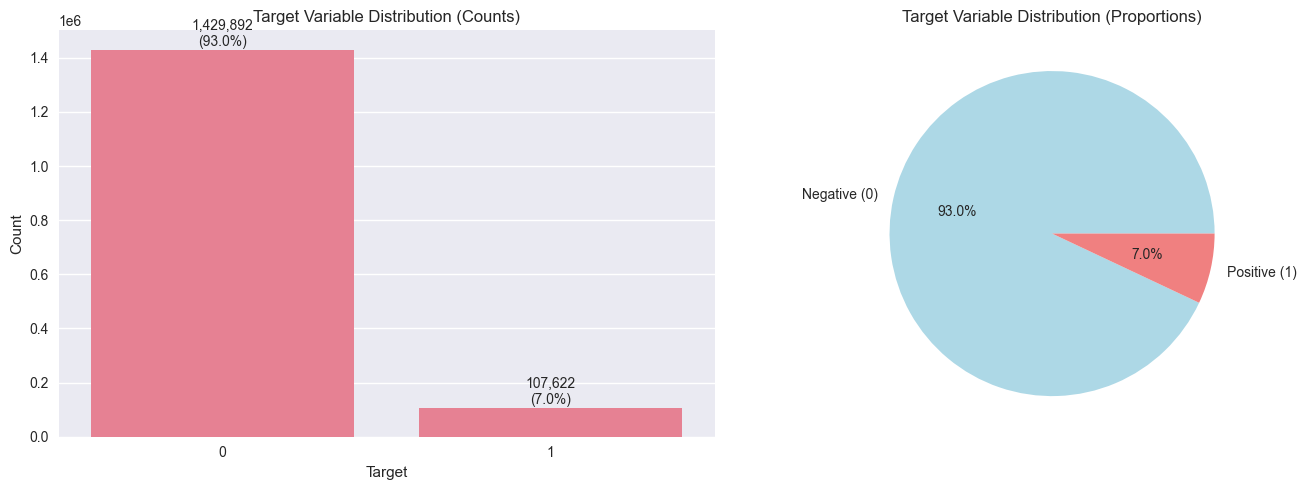

In [5]:
# Target variable distribution
target_counts = df['target'].value_counts()
target_props = df['target'].value_counts(normalize=True)

print("=== Target Variable Distribution ===")
print(f"Class 0 (Negative): {target_counts[0]:,} ({target_props[0]:.1%})")
print(f"Class 1 (Positive): {target_counts[1]:,} ({target_props[1]:.1%})")
print(f"Class Imbalance Ratio: {target_counts[0] / target_counts[1]:.1f}:1")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='target', ax=axes[0])
axes[0].set_title('Target Variable Distribution (Counts)')
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Count')
for i, v in enumerate(target_counts):
    axes[0].text(i, v + 1000, f'{v:,}\n({target_props[i]:.1%})', ha='center', va='bottom')

# Pie chart
axes[1].pie(target_counts, labels=['Negative (0)', 'Positive (1)'], autopct='%1.1f%%', 
           colors=['lightblue', 'lightcoral'])
axes[1].set_title('Target Variable Distribution (Proportions)')

plt.tight_layout()
plt.show()

## 3. Demographic Analysis

In [6]:
# Gender distribution
print("=== Gender Distribution ===")
gender_stats = df.groupby(['gender', 'target']).size().unstack(fill_value=0)
gender_stats['Total'] = gender_stats.sum(axis=1)
gender_stats['Positive_Rate'] = gender_stats[1] / gender_stats['Total']
print(gender_stats)

# Age distribution
print("\n=== Age Analysis ===")
print(f"Age range: {df['age'].min():.0f} - {df['age'].max():.0f} years")
print(f"Mean age: {df['age'].mean():.1f} ± {df['age'].std():.1f} years")
print(f"Median age: {df['age'].median():.0f} years")

# Age group analysis
print("\n=== Age Group Distribution ===")
age_group_stats = df.groupby(['age_group', 'target']).size().unstack(fill_value=0)
age_group_stats['Total'] = age_group_stats.sum(axis=1)
age_group_stats['Positive_Rate'] = age_group_stats[1] / age_group_stats['Total']
print(age_group_stats)

=== Gender Distribution ===
target       0      1   Total  Positive_Rate
gender                                      
F       745237  53929  799166          0.067
M       684655  53693  738348          0.073

=== Age Analysis ===
Age range: 18 - 79 years
Mean age: 47.8 ± 17.2 years
Median age: 48 years

=== Age Group Distribution ===
target          0      1   Total  Positive_Rate
age_group                                      
18-30      313480   7559  321039          0.024
31-45      372913  13423  386336          0.035
46-60      364032  24978  389010          0.064
61-75      342360  46872  389232          0.120
75+         37107  14790   51897          0.285


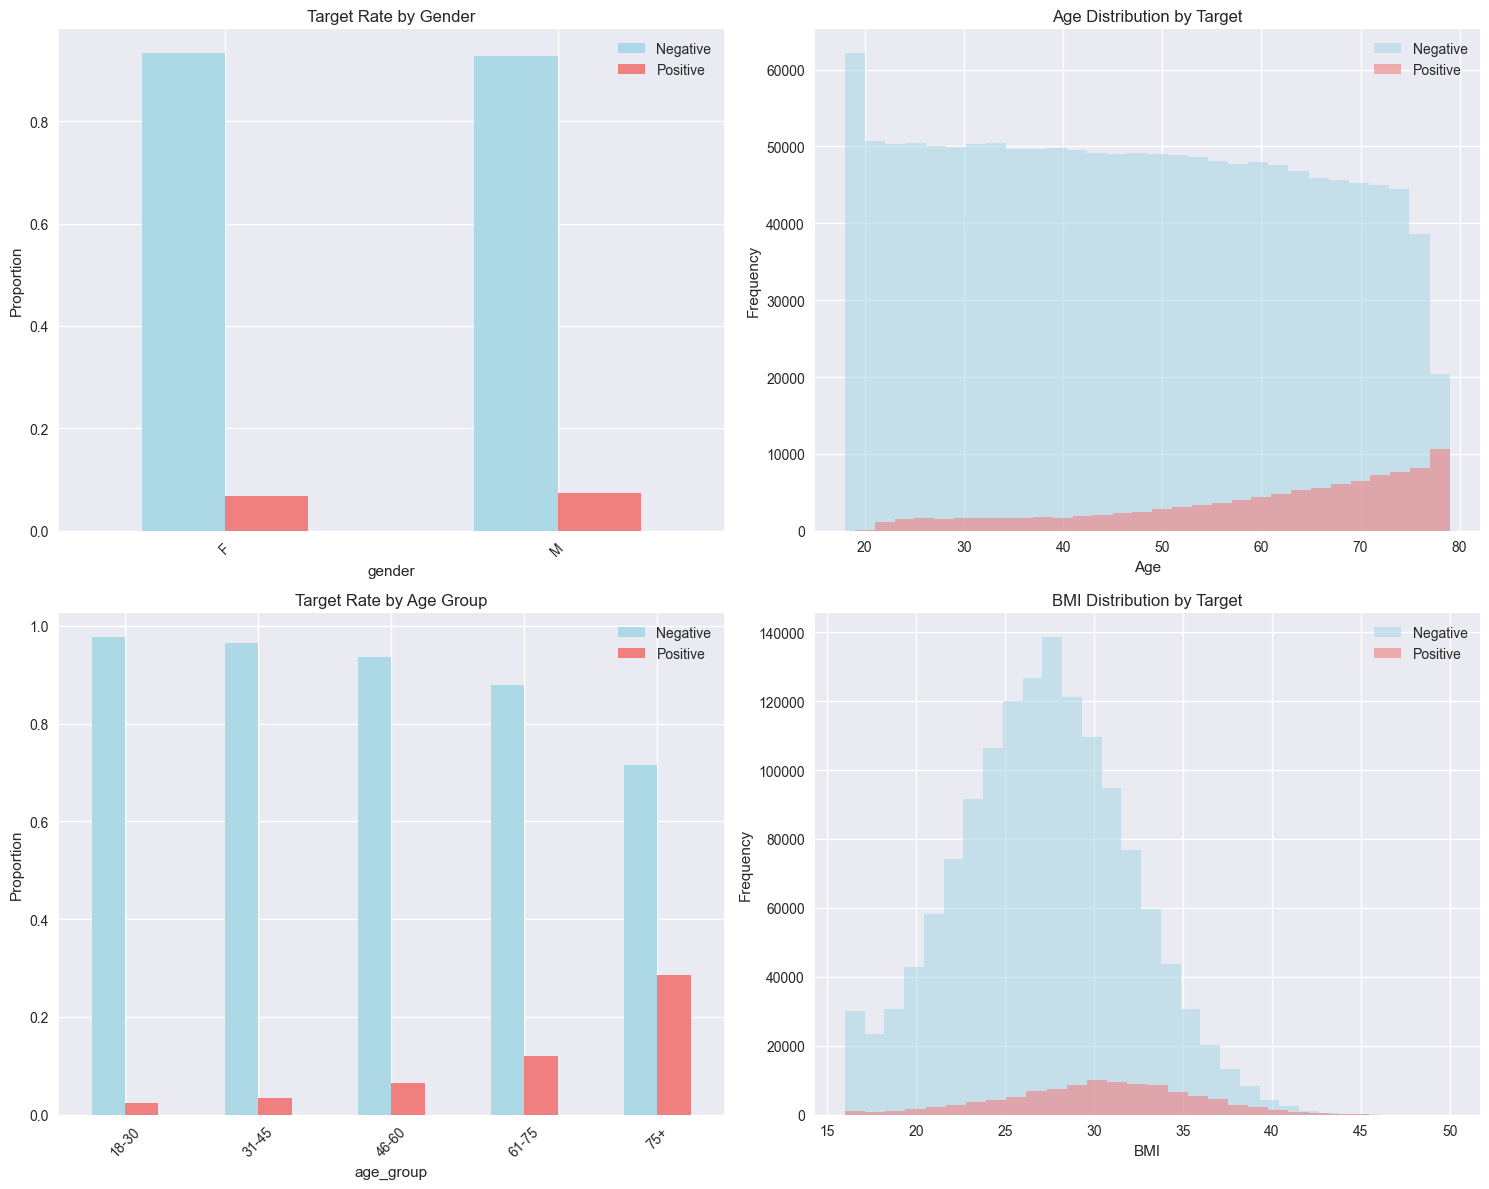

In [7]:
# Visualize demographic distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gender vs Target
gender_cross = pd.crosstab(df['gender'], df['target'], normalize='index')
gender_cross.plot(kind='bar', ax=axes[0,0], color=['lightblue', 'lightcoral'])
axes[0,0].set_title('Target Rate by Gender')
axes[0,0].set_ylabel('Proportion')
axes[0,0].legend(['Negative', 'Positive'])
axes[0,0].tick_params(axis='x', rotation=45)

# Age distribution by target
df[df['target']==0]['age'].hist(alpha=0.6, bins=30, label='Negative', ax=axes[0,1], color='lightblue')
df[df['target']==1]['age'].hist(alpha=0.6, bins=30, label='Positive', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Age Distribution by Target')
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# Age group vs Target
age_group_cross = pd.crosstab(df['age_group'], df['target'], normalize='index')
age_group_cross.plot(kind='bar', ax=axes[1,0], color=['lightblue', 'lightcoral'])
axes[1,0].set_title('Target Rate by Age Group')
axes[1,0].set_ylabel('Proportion')
axes[1,0].legend(['Negative', 'Positive'])
axes[1,0].tick_params(axis='x', rotation=45)

# BMI distribution by target
df[df['target']==0]['bmi'].hist(alpha=0.6, bins=30, label='Negative', ax=axes[1,1], color='lightblue')
df[df['target']==1]['bmi'].hist(alpha=0.6, bins=30, label='Positive', ax=axes[1,1], color='lightcoral')
axes[1,1].set_title('BMI Distribution by Target')
axes[1,1].set_xlabel('BMI')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 4. Clinical Features Analysis

In [8]:
# Clinical features analysis
clinical_features = ['bmi', 'systolic_bp', 'diastolic_bp', 'cholesterol', 'glucose']

print("=== Clinical Features Summary ===")
clinical_summary = df[clinical_features + ['target']].groupby('target')[clinical_features].agg(['mean', 'std', 'median'])
display(clinical_summary.round(2))

# Statistical tests
print("\n=== Statistical Tests (Target 0 vs 1) ===")
for feature in clinical_features:
    group_0 = df[df['target'] == 0][feature]
    group_1 = df[df['target'] == 1][feature]
    
    # T-test
    t_stat, p_value = stats.ttest_ind(group_0, group_1)
    effect_size = (group_1.mean() - group_0.mean()) / np.sqrt((group_0.var() + group_1.var()) / 2)
    
    print(f"{feature}: p-value = {p_value:.2e}, effect size = {effect_size:.3f}")

=== Clinical Features Summary ===


bmi              systolic_bp               diastolic_bp         \
         mean   std median        mean    std median         mean    std   
target                                                                     
0       27.14  4.86   27.1      125.67  15.51  125.7        82.78  10.16   
1       30.29  5.26   30.6      134.38  16.21  135.6        87.83  10.44   

              cholesterol               glucose                
       median        mean    std median    mean    std median  
target                                                         
0        82.8      220.62  35.94  220.6   96.75  15.68   96.5  
1        89.0      231.29  36.27  232.8  108.15  18.49  107.4


=== Statistical Tests (Target 0 vs 1) ===
bmi: p-value = 0.00e+00, effect size = 0.621
systolic_bp: p-value = 0.00e+00, effect size = 0.549
diastolic_bp: p-value = 0.00e+00, effect size = 0.490
cholesterol: p-value = 0.00e+00, effect size = 0.296
glucose: p-value = 0.00e+00, effect size = 0.665


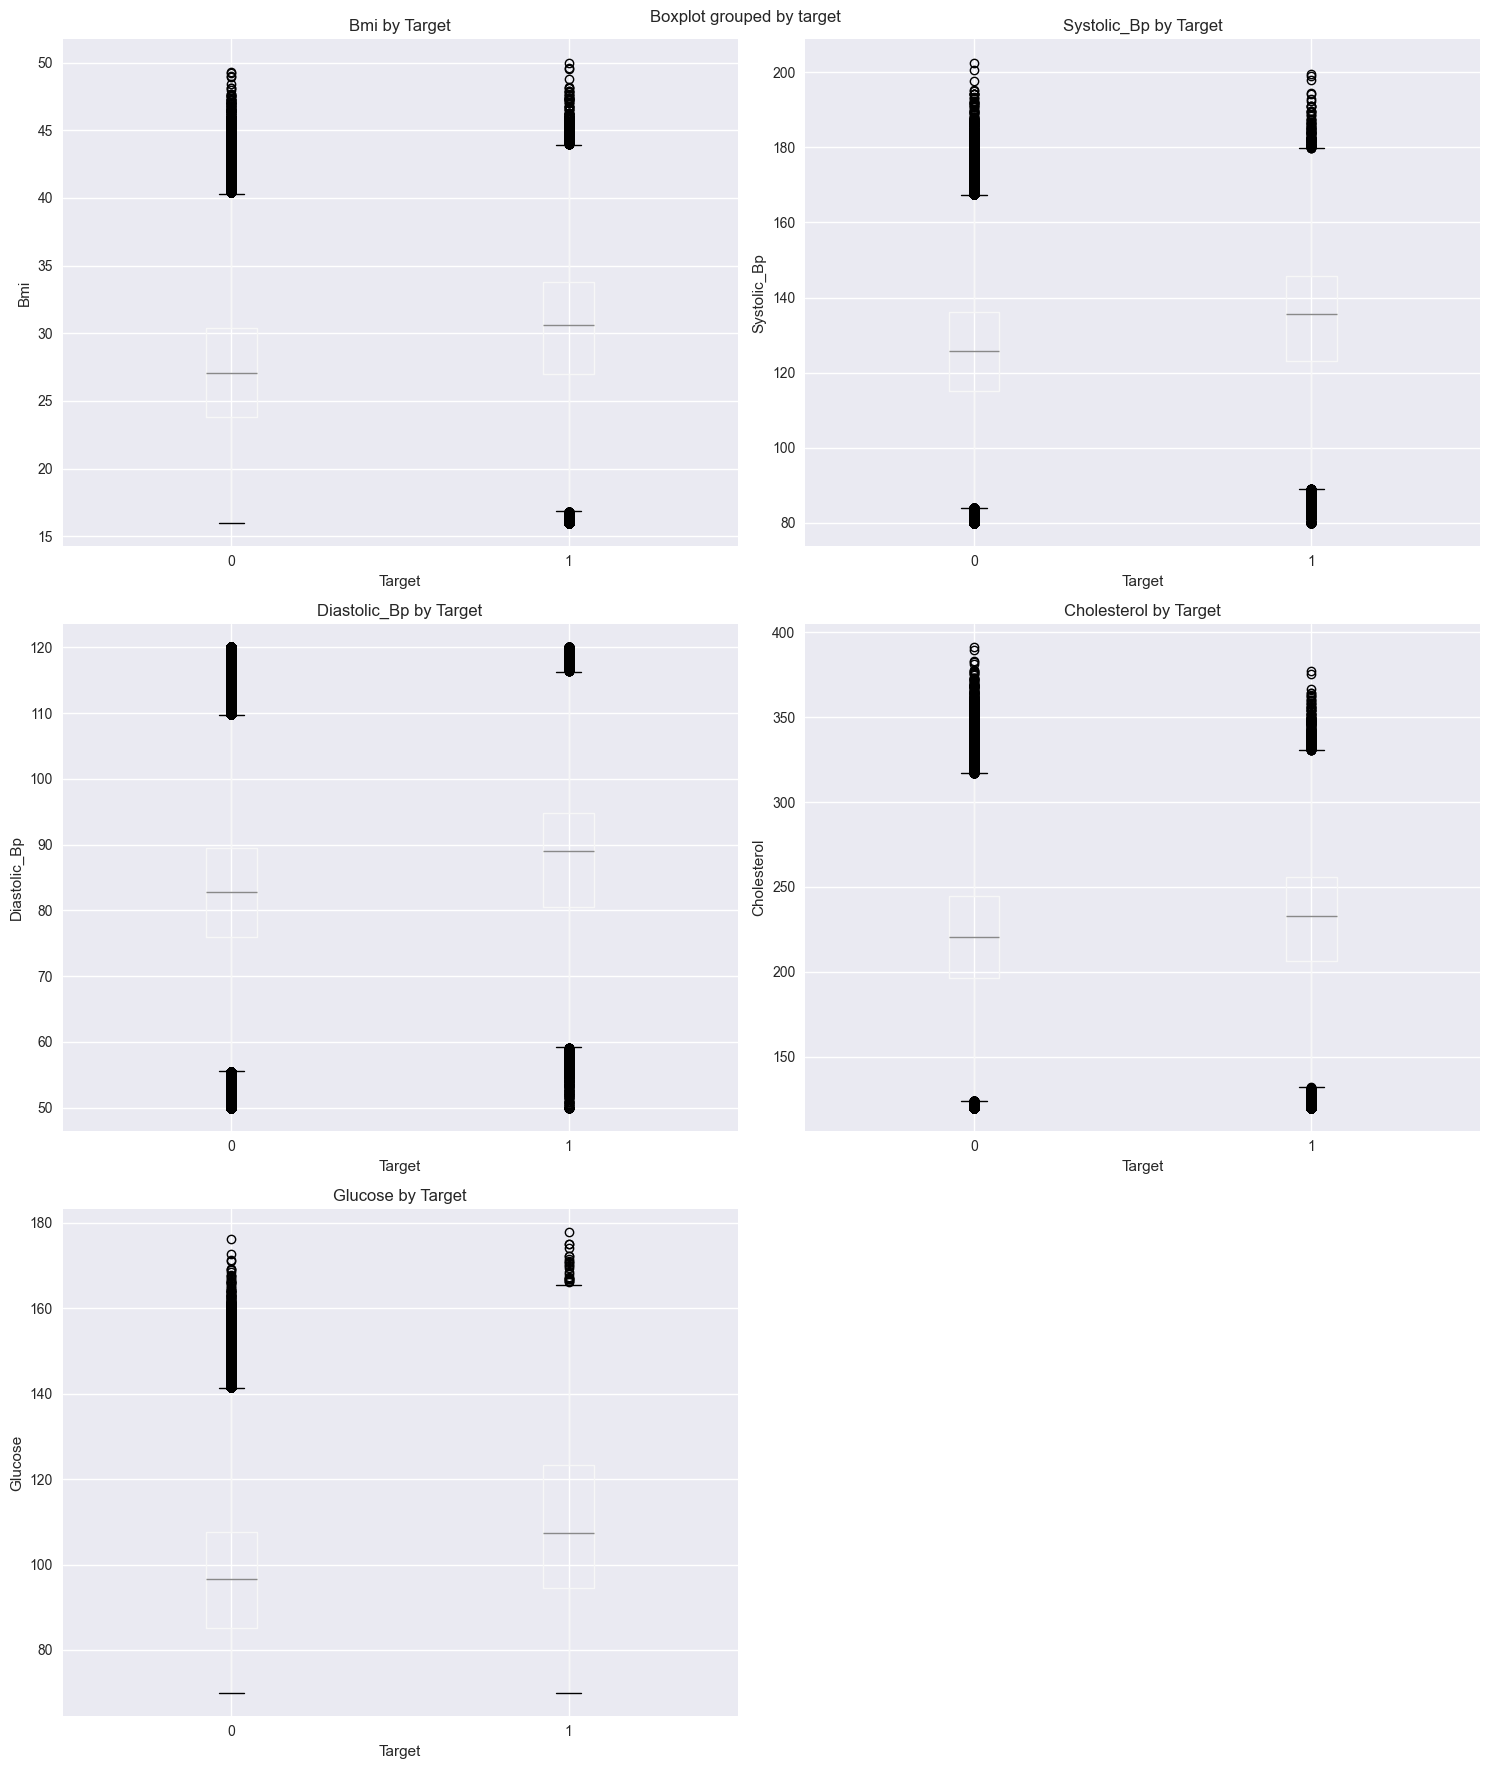

In [9]:
# Visualize clinical features
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()

for i, feature in enumerate(clinical_features):
    # Box plot
    df.boxplot(column=feature, by='target', ax=axes[i])
    axes[i].set_title(f'{feature.title()} by Target')
    axes[i].set_xlabel('Target')
    axes[i].set_ylabel(feature.title())

# Remove the extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

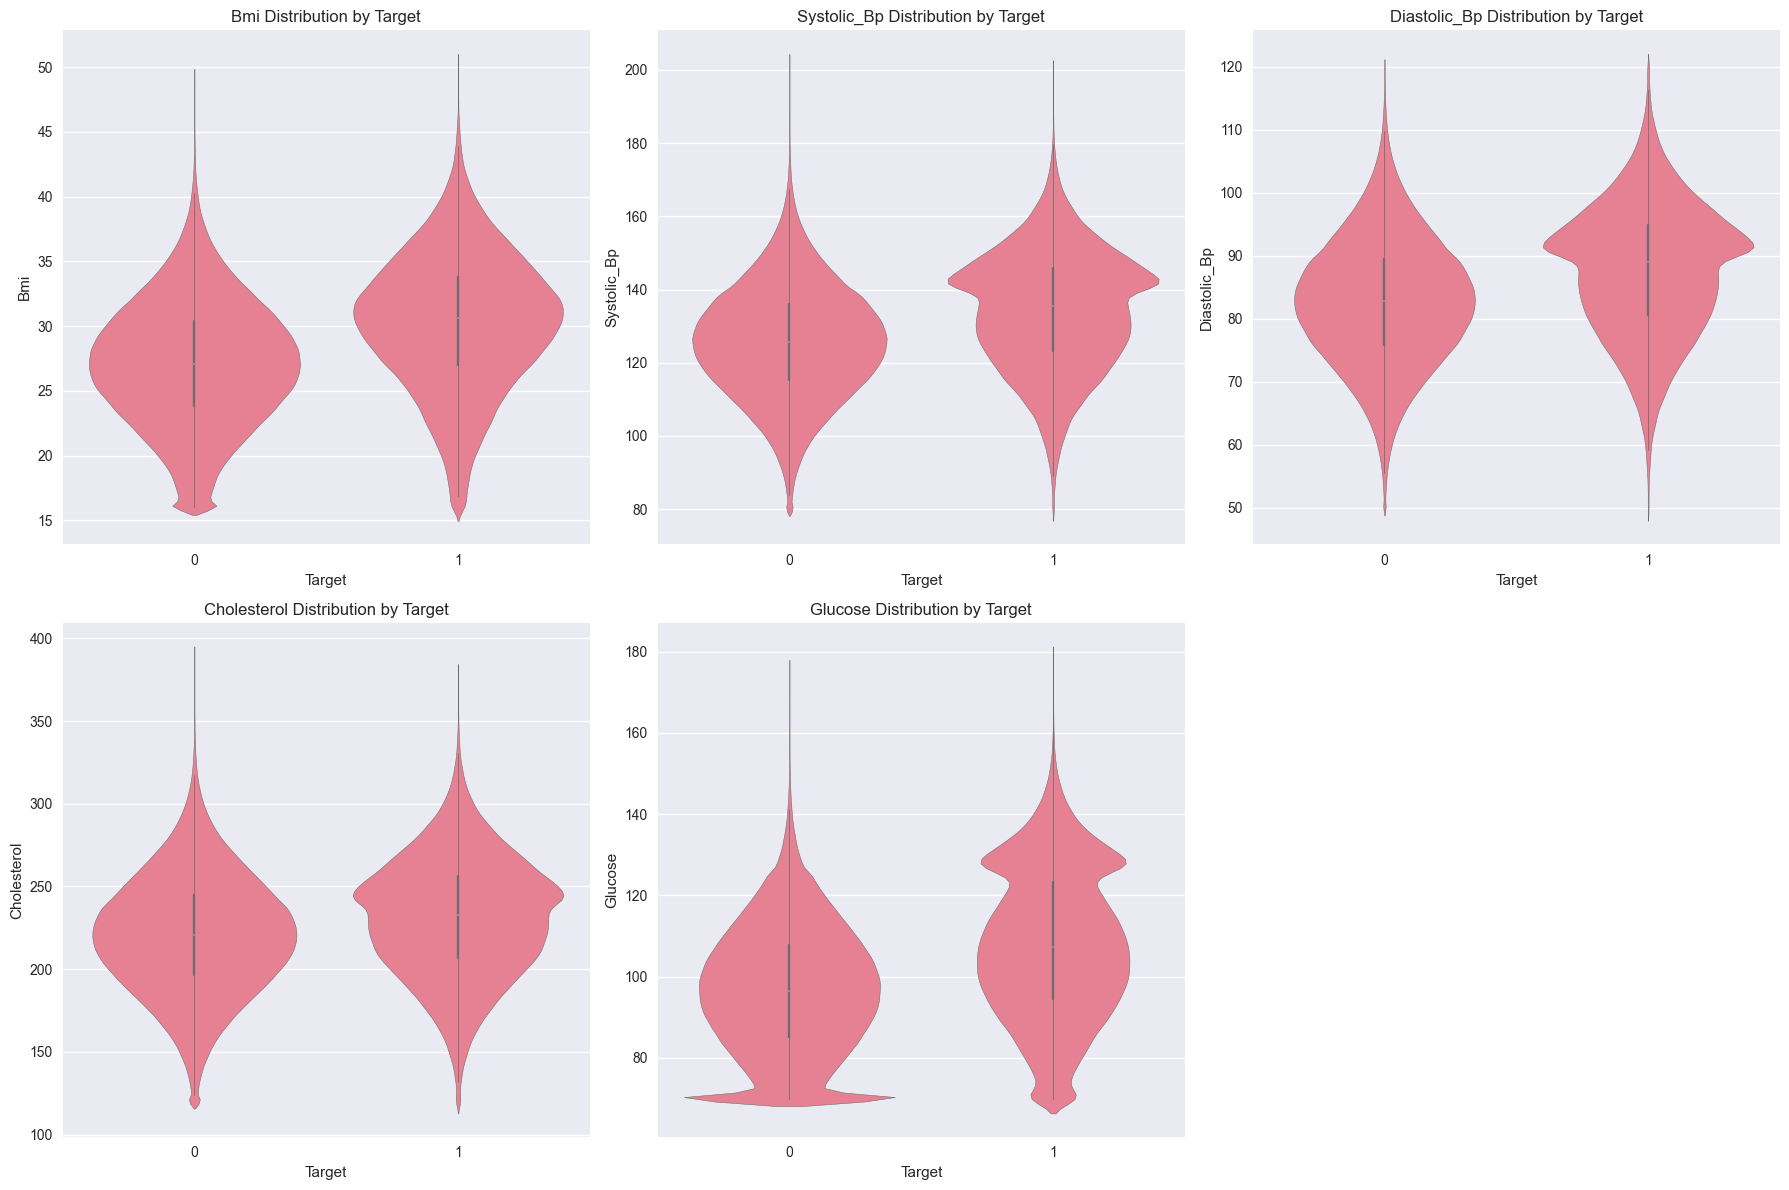

In [10]:
# Violin plots for better distribution visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(clinical_features):
    sns.violinplot(data=df, x='target', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature.title()} Distribution by Target')
    axes[i].set_xlabel('Target')
    axes[i].set_ylabel(feature.title())

# Remove the extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

## 5. Correlation Analysis

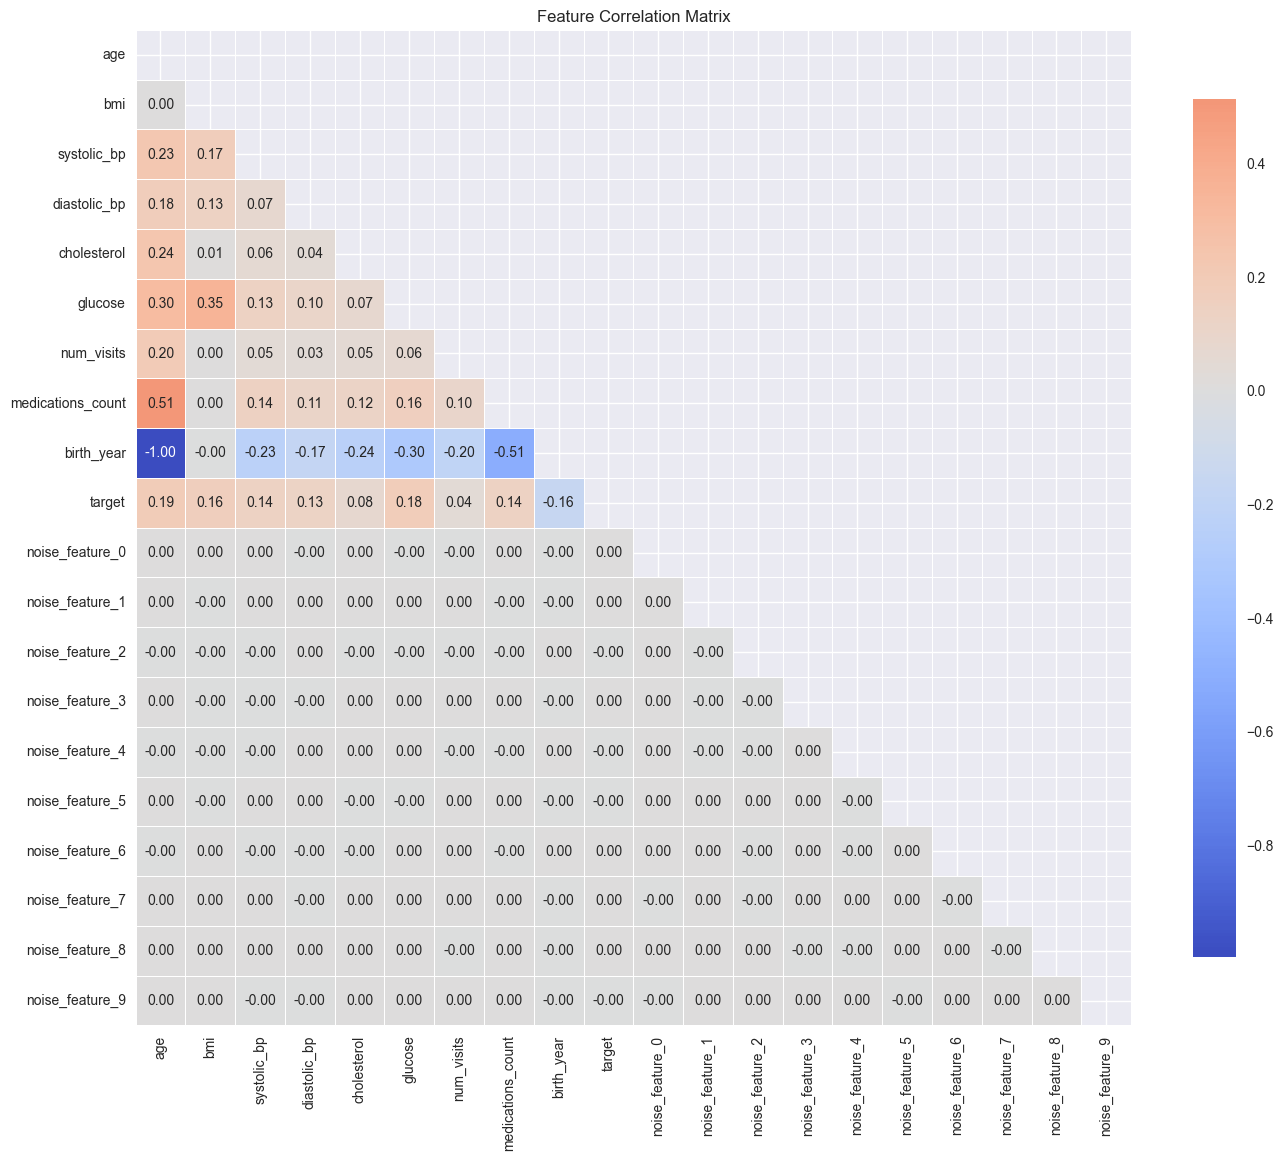

=== Highly Correlated Feature Pairs (|r| > 0.7) ===
age <-> birth_year: -0.997


In [11]:
# Select numeric features for correlation analysis
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID columns and year if they exist
numeric_features = [col for col in numeric_features if col not in ['patient_id', 'year']]

# Calculate correlation matrix
correlation_matrix = df[numeric_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Find highly correlated features
print("=== Highly Correlated Feature Pairs (|r| > 0.7) ===")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

for feature1, feature2, corr in high_corr_pairs:
    print(f"{feature1} <-> {feature2}: {corr:.3f}")

=== Features Most Correlated with Target ===
age                  0.188
glucose              0.180
birth_year           0.163
bmi                  0.162
systolic_bp          0.141
medications_count    0.140
diastolic_bp         0.125
cholesterol          0.076
num_visits           0.042
noise_feature_0      0.001
Name: target, dtype: float64


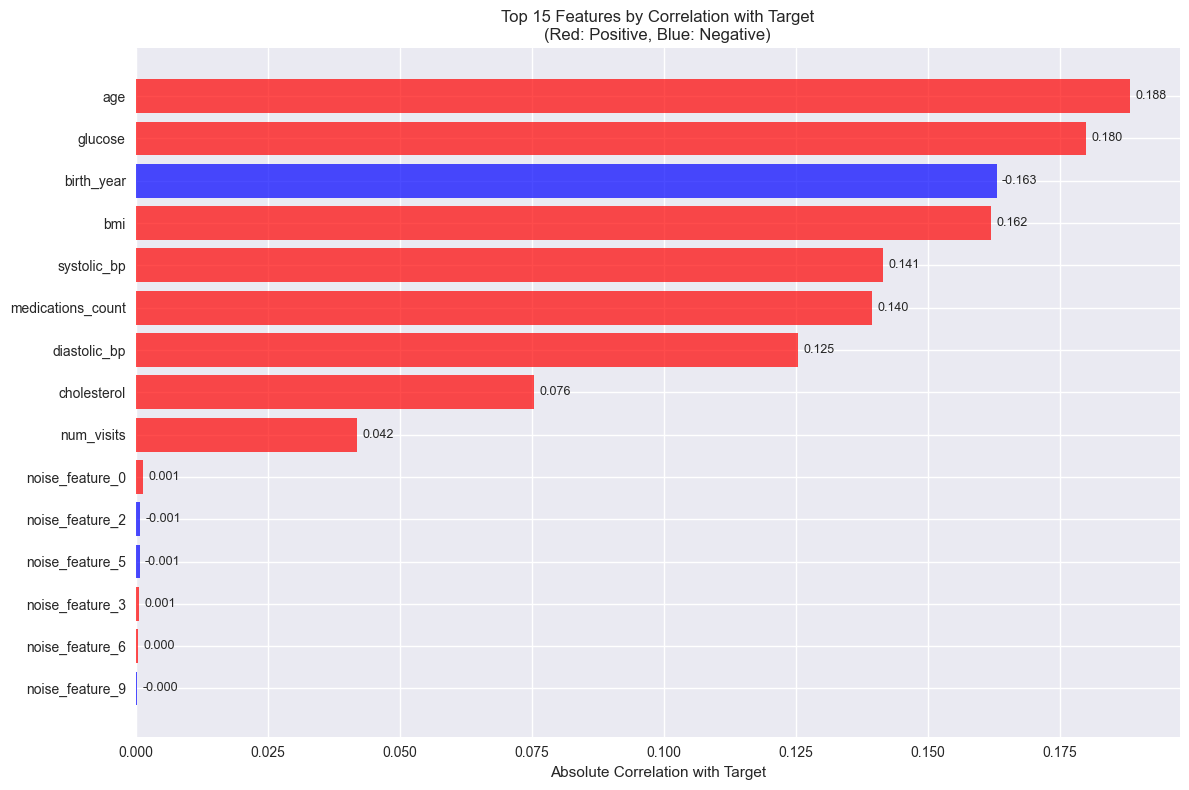

In [12]:
# Target correlation analysis
target_correlations = correlation_matrix['target'].abs().sort_values(ascending=False)
target_correlations = target_correlations[target_correlations.index != 'target']

print("=== Features Most Correlated with Target ===")
print(target_correlations.head(10))

# Plot target correlations
plt.figure(figsize=(12, 8))
top_features = target_correlations.head(15)
colors = ['red' if correlation_matrix.loc[feat, 'target'] > 0 else 'blue' for feat in top_features.index]
bars = plt.barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Absolute Correlation with Target')
plt.title('Top 15 Features by Correlation with Target\n(Red: Positive, Blue: Negative)')
plt.gca().invert_yaxis()

# Add correlation values as text
for i, (feat, val) in enumerate(top_features.items()):
    actual_corr = correlation_matrix.loc[feat, 'target']
    plt.text(val + 0.001, i, f'{actual_corr:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 6. Temporal Analysis

=== Temporal Analysis ===
      Total_Records  Positive_Cases  Positive_Rate  Avg_Age  Avg_BMI
year                                                                
2015         300672             131          0.000   46.526   27.155
2016         305842            1098          0.004   47.027   27.260
2017         311000            6139          0.020   47.529   27.361
2018         310000           24937          0.080   48.526   27.464
2019         310000           75317          0.243   49.526   27.567


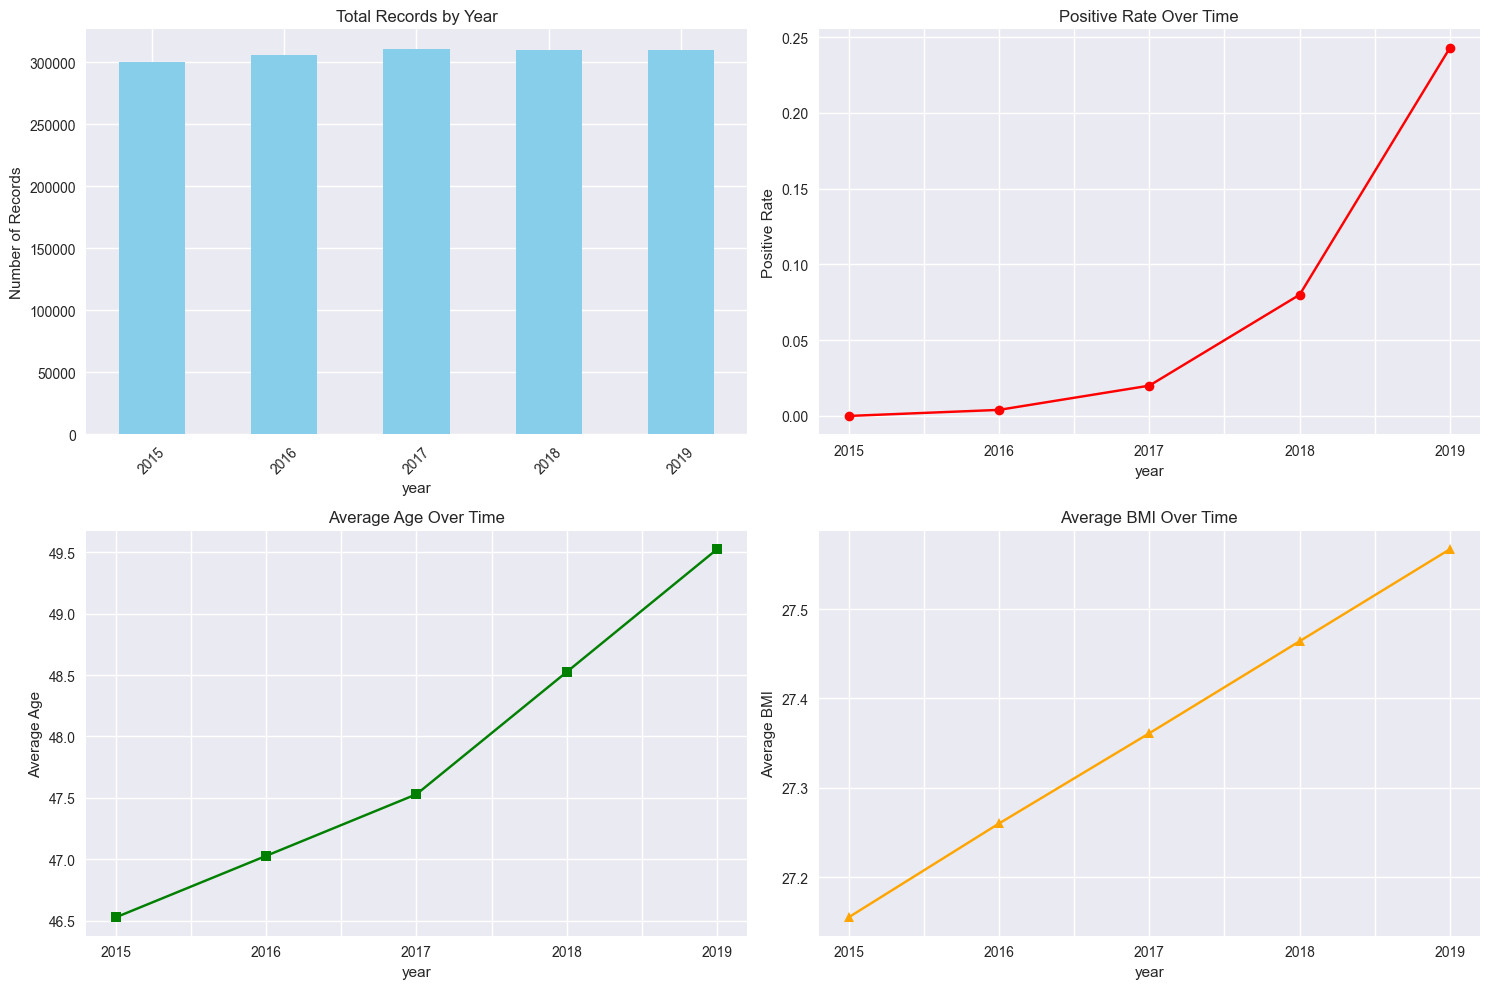

In [13]:
# Check if temporal features exist
if 'year' in df.columns:
    print("=== Temporal Analysis ===")
    
    # Year distribution
    year_stats = df.groupby('year').agg({
        'target': ['count', 'sum', 'mean'],
        'age': 'mean',
        'bmi': 'mean'
    }).round(3)
    year_stats.columns = ['Total_Records', 'Positive_Cases', 'Positive_Rate', 'Avg_Age', 'Avg_BMI']
    print(year_stats)
    
    # Plot temporal trends
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Records per year
    year_stats['Total_Records'].plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('Total Records by Year')
    axes[0,0].set_ylabel('Number of Records')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Positive rate over time
    year_stats['Positive_Rate'].plot(kind='line', marker='o', ax=axes[0,1], color='red')
    axes[0,1].set_title('Positive Rate Over Time')
    axes[0,1].set_ylabel('Positive Rate')
    axes[0,1].grid(True)
    
    # Average age over time
    year_stats['Avg_Age'].plot(kind='line', marker='s', ax=axes[1,0], color='green')
    axes[1,0].set_title('Average Age Over Time')
    axes[1,0].set_ylabel('Average Age')
    axes[1,0].grid(True)
    
    # Average BMI over time
    year_stats['Avg_BMI'].plot(kind='line', marker='^', ax=axes[1,1], color='orange')
    axes[1,1].set_title('Average BMI Over Time')
    axes[1,1].set_ylabel('Average BMI')
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No temporal features (year) found in the dataset.")

## 7. Missing Data Analysis

In [14]:
# Missing data analysis
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percent
}).sort_values('Missing_Count', ascending=False)

missing_df = missing_df[missing_df['Missing_Count'] > 0]

if len(missing_df) > 0:
    print("=== Missing Data Summary ===")
    print(missing_df)
    
    # Visualize missing data
    if len(missing_df) > 0:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        missing_df['Missing_Count'].plot(kind='bar', color='salmon')
        plt.title('Missing Data Count by Feature')
        plt.ylabel('Missing Count')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 2, 2)
        missing_df['Missing_Percentage'].plot(kind='bar', color='lightcoral')
        plt.title('Missing Data Percentage by Feature')
        plt.ylabel('Missing Percentage (%)')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Missing data patterns
        if len(missing_df) > 1:
            import missingno as msno
            plt.figure(figsize=(12, 6))
            msno.matrix(df[missing_df.index.tolist()])
            plt.title('Missing Data Pattern')
            plt.show()
            
else:
    print("=== No Missing Data Found ===")
    print("The dataset is complete with no missing values.")

=== No Missing Data Found ===
The dataset is complete with no missing values.


## 8. Outlier Detection

In [15]:
# Outlier detection using IQR method
def detect_outliers_iqr(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("=== Outlier Analysis (IQR Method) ===")
outlier_summary = []

for feature in clinical_features:
    outliers, lower, upper = detect_outliers_iqr(df, feature)
    outlier_summary.append({
        'Feature': feature,
        'Outlier_Count': len(outliers),
        'Outlier_Percentage': len(outliers) / len(df) * 100,
        'Lower_Bound': lower,
        'Upper_Bound': upper
    })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.round(3))

=== Outlier Analysis (IQR Method) ===
        Feature  Outlier_Count  Outlier_Percentage  Lower_Bound  Upper_Bound
0           bmi           5847               0.380        13.95        40.75
1   systolic_bp          10697               0.696        83.90       168.70
2  diastolic_bp          10531               0.685        55.35       110.95
3   cholesterol          10799               0.702       123.95       318.75
4       glucose           5236               0.341        51.35       142.95


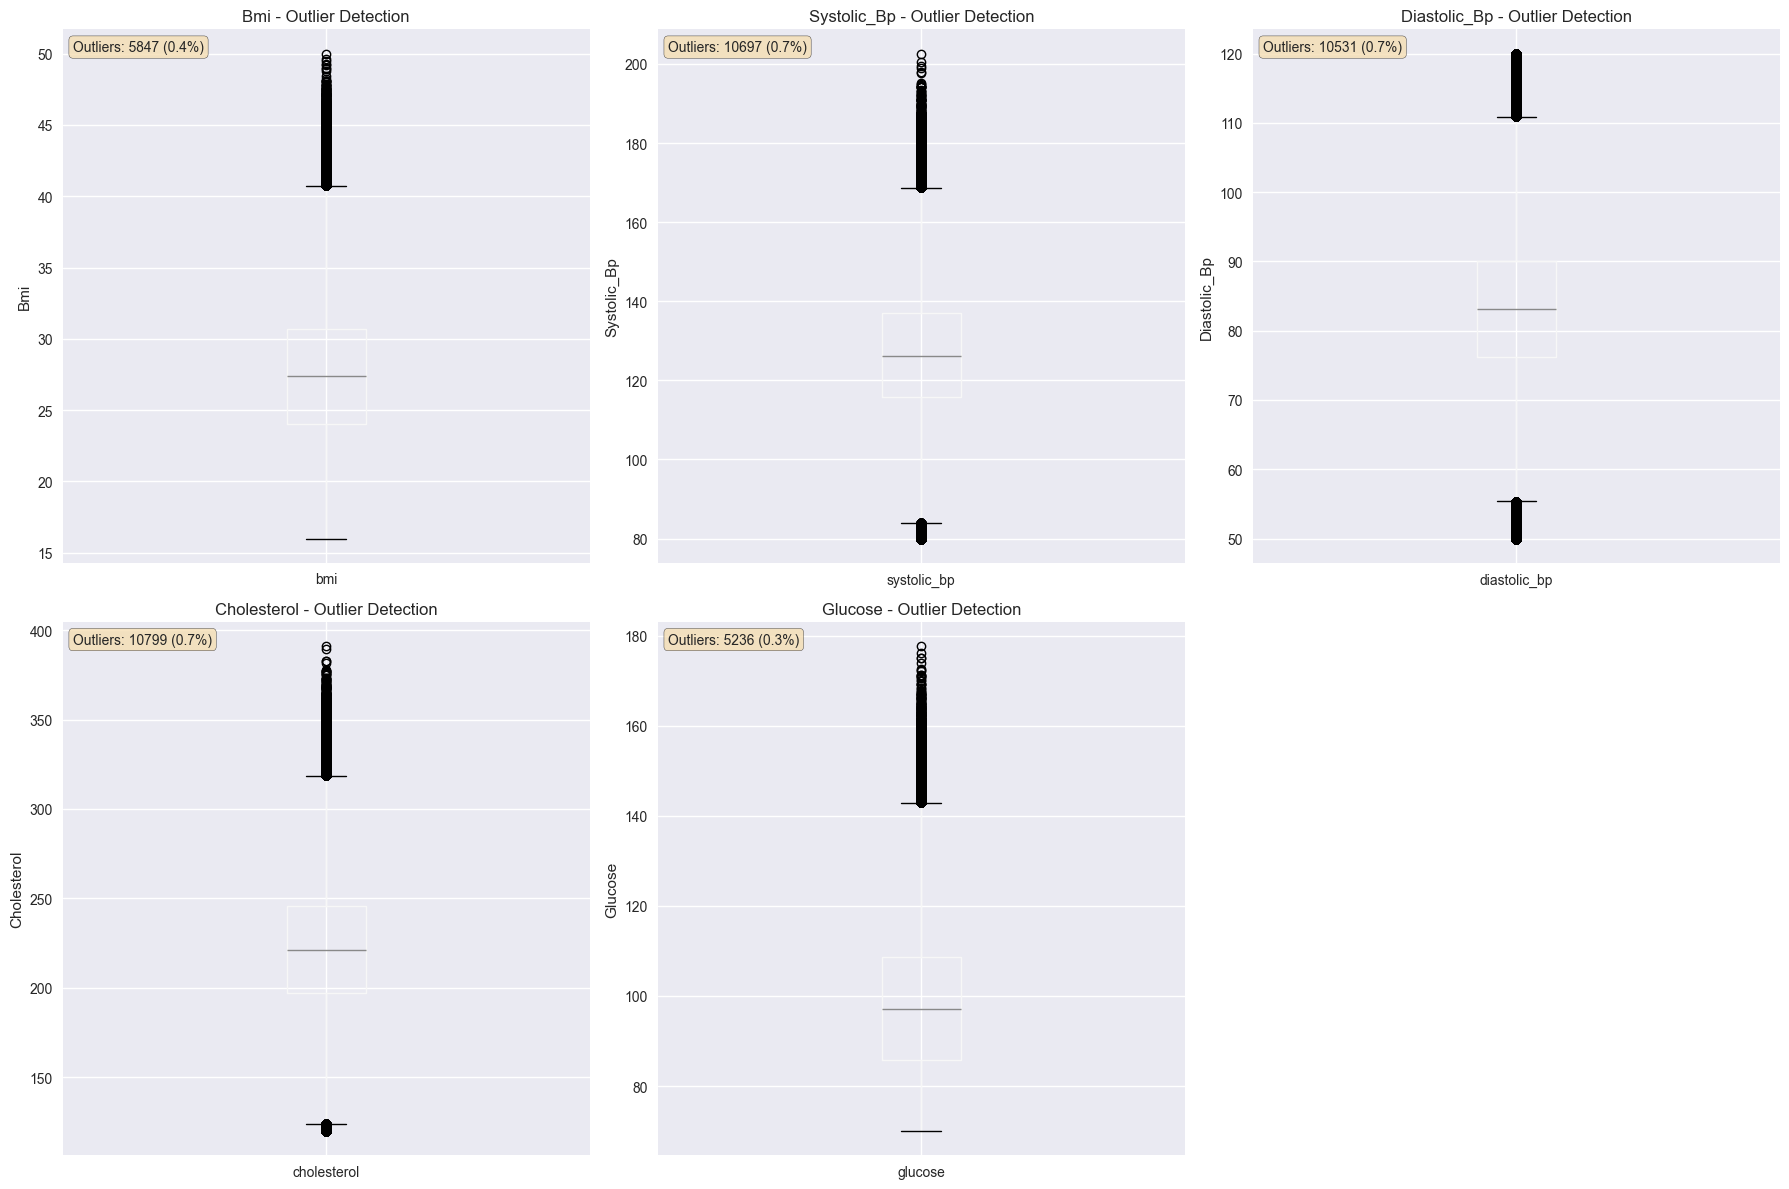

In [16]:
# Visualize outliers
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(clinical_features):
    # Box plot with outliers
    df.boxplot(column=feature, ax=axes[i])
    axes[i].set_title(f'{feature.title()} - Outlier Detection')
    axes[i].set_ylabel(feature.title())
    
    # Add statistics
    outliers, lower, upper = detect_outliers_iqr(df, feature)
    axes[i].text(0.02, 0.98, f'Outliers: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)', 
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Remove the extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

In [17]:
# Isolation Forest for multivariate outlier detection
# Select numeric features for outlier detection
features_for_outliers = clinical_features
X_outliers = df[features_for_outliers].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_outliers)

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(X_scaled)

# Add outlier labels to dataframe
df_with_outliers = df.copy()
df_with_outliers['outlier'] = outlier_labels

print("=== Multivariate Outlier Detection (Isolation Forest) ===")
print(f"Total outliers detected: {sum(outlier_labels == -1):,} ({sum(outlier_labels == -1)/len(df)*100:.2f}%)")
print(f"Normal observations: {sum(outlier_labels == 1):,} ({sum(outlier_labels == 1)/len(df)*100:.2f}%)")

# Compare target distribution in outliers vs normal
outlier_target_dist = df_with_outliers.groupby('outlier')['target'].agg(['count', 'sum', 'mean'])
outlier_target_dist.columns = ['Total', 'Positive_Cases', 'Positive_Rate']
outlier_target_dist.index = ['Outlier', 'Normal']
print("\nTarget distribution in outliers vs normal observations:")
print(outlier_target_dist)

=== Multivariate Outlier Detection (Isolation Forest) ===
Total outliers detected: 76,876 (5.00%)
Normal observations: 1,460,638 (95.00%)

Target distribution in outliers vs normal observations:
           Total  Positive_Cases  Positive_Rate
Outlier    76876           13113          0.171
Normal   1460638           94509          0.065


## 9. Feature Engineering Insights

In [18]:
# Feature engineering insights
print("=== Feature Engineering Opportunities ===")

# 1. BMI categories
df_fe = df.copy()
df_fe['bmi_category'] = pd.cut(df_fe['bmi'], 
                              bins=[0, 18.5, 25, 30, float('inf')],
                              labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

bmi_target_rate = df_fe.groupby('bmi_category')['target'].agg(['count', 'mean'])
print("\n1. BMI Categories vs Target Rate:")
print(bmi_target_rate)

# 2. Blood pressure categories
def categorize_bp(systolic, diastolic):
    if systolic < 120 and diastolic < 80:
        return 'Normal'
    elif systolic < 130 and diastolic < 80:
        return 'Elevated'
    elif systolic < 140 or diastolic < 90:
        return 'Stage 1 Hypertension'
    else:
        return 'Stage 2 Hypertension'

df_fe['bp_category'] = df_fe.apply(lambda x: categorize_bp(x['systolic_bp'], x['diastolic_bp']), axis=1)
bp_target_rate = df_fe.groupby('bp_category')['target'].agg(['count', 'mean'])
print("\n2. Blood Pressure Categories vs Target Rate:")
print(bp_target_rate)

# 3. Age-BMI interaction
df_fe['age_bmi_interaction'] = df_fe['age'] * df_fe['bmi']
age_bmi_corr = df_fe['age_bmi_interaction'].corr(df_fe['target'])
print(f"\n3. Age-BMI Interaction correlation with target: {age_bmi_corr:.4f}")

# 4. Risk score calculation
# Simple risk score based on clinical guidelines
df_fe['risk_score'] = (
    (df_fe['age'] > 65) * 1 +
    (df_fe['bmi'] > 30) * 1 +
    (df_fe['systolic_bp'] > 140) * 1 +
    (df_fe['glucose'] > 126) * 1 +
    (df_fe['cholesterol'] > 240) * 1
)

risk_score_rate = df_fe.groupby('risk_score')['target'].agg(['count', 'mean'])
print("\n4. Risk Score vs Target Rate:")
print(risk_score_rate)

=== Feature Engineering Opportunities ===

1. BMI Categories vs Target Rate:
               count   mean
bmi_category               
Underweight    62908  0.034
Normal        432810  0.035
Overweight    588754  0.055
Obese         453042  0.128

2. Blood Pressure Categories vs Target Rate:
                        count   mean
bp_category                         
Elevated               146712  0.028
Normal                 215108  0.020
Stage 1 Hypertension  1090115  0.077
Stage 2 Hypertension    85579  0.183

3. Age-BMI Interaction correlation with target: 0.2507

4. Risk Score vs Target Rate:
             count   mean
risk_score               
0           539935  0.016
1           565478  0.047
2           301702  0.119
3           103506  0.242
4            24038  0.413
5             2855  0.636


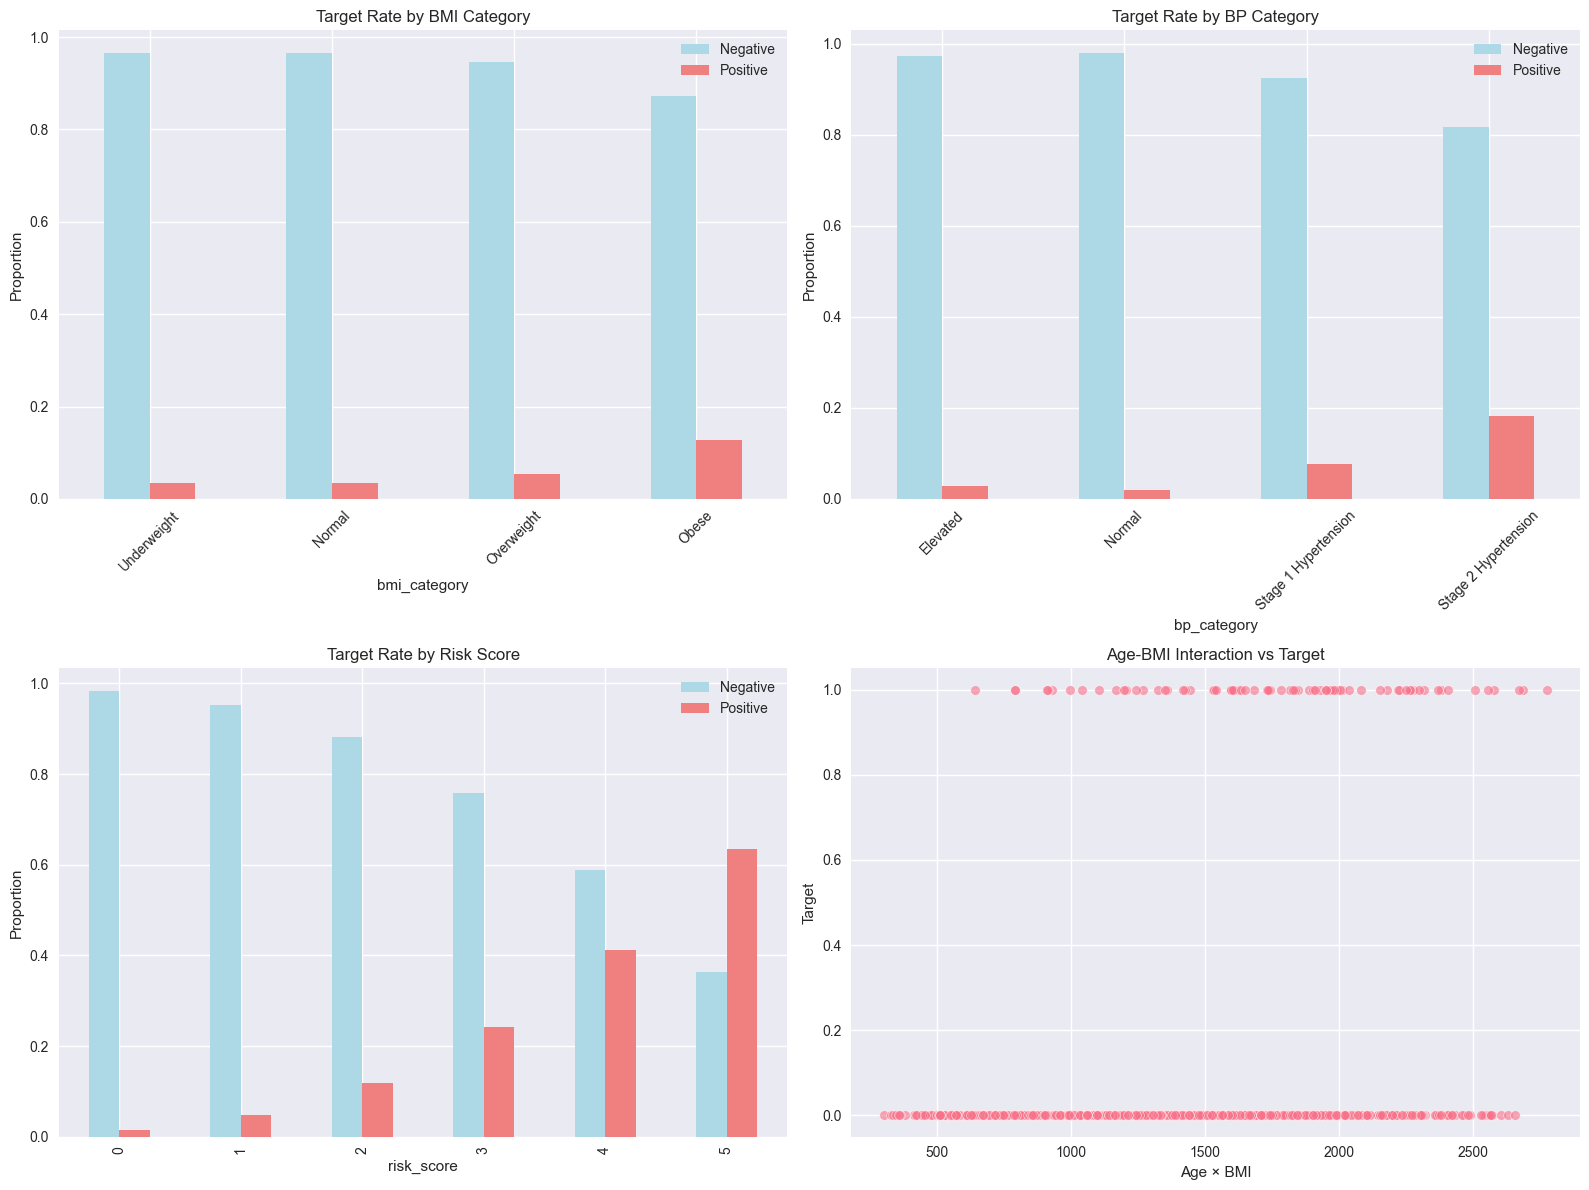

In [19]:
# Visualize feature engineering insights
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# BMI categories
bmi_cross = pd.crosstab(df_fe['bmi_category'], df_fe['target'], normalize='index')
bmi_cross.plot(kind='bar', ax=axes[0,0], color=['lightblue', 'lightcoral'])
axes[0,0].set_title('Target Rate by BMI Category')
axes[0,0].set_ylabel('Proportion')
axes[0,0].legend(['Negative', 'Positive'])
axes[0,0].tick_params(axis='x', rotation=45)

# Blood pressure categories
bp_cross = pd.crosstab(df_fe['bp_category'], df_fe['target'], normalize='index')
bp_cross.plot(kind='bar', ax=axes[0,1], color=['lightblue', 'lightcoral'])
axes[0,1].set_title('Target Rate by BP Category')
axes[0,1].set_ylabel('Proportion')
axes[0,1].legend(['Negative', 'Positive'])
axes[0,1].tick_params(axis='x', rotation=45)

# Risk score distribution
risk_cross = pd.crosstab(df_fe['risk_score'], df_fe['target'], normalize='index')
risk_cross.plot(kind='bar', ax=axes[1,0], color=['lightblue', 'lightcoral'])
axes[1,0].set_title('Target Rate by Risk Score')
axes[1,0].set_ylabel('Proportion')
axes[1,0].legend(['Negative', 'Positive'])

# Age-BMI interaction vs target
sns.scatterplot(data=df_fe.sample(1000), x='age_bmi_interaction', y='target', 
                alpha=0.6, ax=axes[1,1])
axes[1,1].set_title('Age-BMI Interaction vs Target')
axes[1,1].set_xlabel('Age × BMI')
axes[1,1].set_ylabel('Target')

plt.tight_layout()
plt.show()

## 10. Data Quality Assessment & Recommendations

In [20]:
# Data quality assessment
print("=== DATA QUALITY ASSESSMENT ===")

# 1. Dataset size and completeness
print(f"\n1. DATASET OVERVIEW:")
print(f"   • Total records: {len(df):,}")
print(f"   • Total features: {len(df.columns)}")
print(f"   • Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"   • Completeness: {(1 - df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100:.2f}%")

# 2. Target distribution
print(f"\n2. TARGET DISTRIBUTION:")
print(f"   • Class balance: {target_props[0]:.1%} negative, {target_props[1]:.1%} positive")
print(f"   • Imbalance ratio: {target_counts[0] / target_counts[1]:.1f}:1")
imbalance_severity = "Severe" if target_counts[0] / target_counts[1] > 10 else "Moderate" if target_counts[0] / target_counts[1] > 3 else "Mild"
print(f"   • Imbalance severity: {imbalance_severity}")

# 3. Feature quality
print(f"\n3. FEATURE QUALITY:")
print(f"   • Numeric features: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"   • Categorical features: {len(df.select_dtypes(include=['object', 'category']).columns)}")
print(f"   • Features with missing data: {len(missing_df)}")
print(f"   • Highly correlated pairs (|r| > 0.7): {len(high_corr_pairs)}")

# 4. Outlier assessment
total_outliers = sum([row['Outlier_Count'] for _, row in outlier_df.iterrows()])
avg_outlier_rate = total_outliers / (len(clinical_features) * len(df)) * 100
print(f"\n4. OUTLIER ASSESSMENT:")
print(f"   • Average outlier rate: {avg_outlier_rate:.2f}%")
print(f"   • Multivariate outliers: {sum(outlier_labels == -1):,} ({sum(outlier_labels == -1)/len(df)*100:.2f}%)")

# 5. Feature importance indicators
top_corr_features = target_correlations.head(5)
print(f"\n5. PREDICTIVE FEATURES:")
print(f"   • Top correlated with target: {', '.join(top_corr_features.index[:3])}")
print(f"   • Strongest correlation: {top_corr_features.iloc[0]:.3f}")

print("\n" + "="*80)
print("RECOMMENDATIONS FOR MODEL DEVELOPMENT")
print("="*80)

print("\n🎯 CLASS IMBALANCE:")
if imbalance_severity in ["Severe", "Moderate"]:
    print("   • Use SMOTE or other oversampling techniques")
    print("   • Consider cost-sensitive learning")
    print("   • Focus on precision-recall metrics rather than accuracy")
else:
    print("   • Mild imbalance - standard techniques should work")

print("\n🔧 FEATURE ENGINEERING:")
print("   • Create BMI and blood pressure categories")
print("   • Engineer age-BMI and other clinical interactions")
print("   • Develop composite risk scores")
print("   • Consider polynomial features for non-linear relationships")

if len(high_corr_pairs) > 0:
    print("\n🔍 MULTICOLLINEARITY:")
    print("   • Remove or combine highly correlated features")
    print("   • Consider PCA for dimensionality reduction")
    print("   • Use regularization (L1/L2) in models")

print("\n📊 DATA PREPROCESSING:")
if avg_outlier_rate > 5:
    print("   • Consider outlier treatment (capping, transformation)")
print("   • Standardize/normalize features for distance-based models")
print("   • Consider robust scaling due to outliers")

print("\n🤖 MODEL SELECTION:")
print("   • Tree-based models (LightGBM, XGBoost) for non-linear patterns")
print("   • Ensemble methods for improved performance")
print("   • Consider neural networks for complex interactions")

print("\n✅ VALIDATION STRATEGY:")
print("   • Use stratified cross-validation")
print("   • Implement temporal validation if time component exists")
print("   • Monitor for overfitting with diverse validation sets")

print("\n📈 PERFORMANCE METRICS:")
print("   • Primary: ROC-AUC, PR-AUC")
print("   • Secondary: F1-score, Precision, Recall")
print("   • Consider calibration metrics (Brier score, ECE)")
print("   • Fairness metrics across demographic groups")

=== DATA QUALITY ASSESSMENT ===

1. DATASET OVERVIEW:
   • Total records: 1,537,514
   • Total features: 29
   • Memory usage: 685.52 MB
   • Completeness: 100.00%

2. TARGET DISTRIBUTION:
   • Class balance: 93.0% negative, 7.0% positive
   • Imbalance ratio: 13.3:1
   • Imbalance severity: Severe

3. FEATURE QUALITY:
   • Numeric features: 20
   • Categorical features: 8
   • Features with missing data: 0
   • Highly correlated pairs (|r| > 0.7): 1

4. OUTLIER ASSESSMENT:
   • Average outlier rate: 0.56%
   • Multivariate outliers: 76,876 (5.00%)

5. PREDICTIVE FEATURES:
   • Top correlated with target: age, glucose, birth_year
   • Strongest correlation: 0.188

RECOMMENDATIONS FOR MODEL DEVELOPMENT

🎯 CLASS IMBALANCE:
   • Use SMOTE or other oversampling techniques
   • Consider cost-sensitive learning
   • Focus on precision-recall metrics rather than accuracy

🔧 FEATURE ENGINEERING:
   • Create BMI and blood pressure categories
   • Engineer age-BMI and other clinical interactions

## Summary

This EDA has provided comprehensive insights into the clinical dataset:

### Key Findings:
1. **Dataset Quality**: Large, well-structured dataset with minimal missing data
2. **Class Imbalance**: Significant imbalance requiring specialized handling
3. **Feature Relationships**: Several features show strong correlations with target
4. **Clinical Patterns**: Clear associations between clinical measures and outcomes
5. **Engineering Opportunities**: Multiple avenues for creating informative features

### Next Steps:
1. Implement recommended preprocessing steps
2. Create engineered features based on clinical domain knowledge
3. Apply appropriate sampling techniques for class imbalance
4. Develop baseline models using insights from this analysis
5. Establish comprehensive evaluation framework

The dataset shows strong potential for developing an effective clinical prediction model with proper preprocessing and feature engineering.